# Regression: Predict Singapore Interest Rates

Predict interest rates using Linear Regression.

The dataset consists of 6 month windows of interest rates, and your task is to train a Linear Regression model that predicts the next month's interest rate, given the past 5 months.

Data source: [Monetary Authority of Singapore](https://secure.mas.gov.sg/msb/InterestRatesOfBanksAndFinanceCompanies.aspx)

Attributes:
- current_date: the current year and month (for reference only, do NOT use for training/prediction)
- t-5: interest rate at (current_date - 5 months), in % p.a.
- t-4: interest rate at (current_date - 4 months), in % p.a.
- t-3: interest rate at (current_date - 3 months), in % p.a.
- t-2: interest rate at (current_date - 2 months), in % p.a.
- t-1: interest rate at (current_date - 1 month), in % p.a.

Target variable to predict:
- current_rate: interest rate at current_date, in % p.a.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import numpy as np

%matplotlib inline

## Load data

Use pd.read_csv to load the data

In [77]:
df = pd.read_csv('./sg-interest-rates/prime_lending_rates_1983-2018_6mth_window.csv', parse_dates=['current_date'])
df.head()

# either: parse_dates=['current_date']
# or: df[current_date] = pd.to_datetime(df[current_date])

,current_date,t-5,t-4,t-3,t-2,t-1,current_rate
0,1983-06-01,9.53,9.25,9.10,9.03,9.03,8.88
1,1983-07-01,9.25,9.10,9.03,9.03,8.88,9.00
2,1983-08-01,9.10,9.03,9.03,8.88,9.00,9.00
3,1983-09-01,9.03,9.03,8.88,9.00,9.00,8.95
4,1983-10-01,9.03,8.88,9.00,9.00,8.95,8.93


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 7 columns):
current_date    424 non-null datetime64[ns]
t-5             429 non-null float64
t-4             428 non-null float64
t-3             427 non-null float64
t-2             426 non-null float64
t-1             425 non-null float64
current_rate    424 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 23.5 KB


In [80]:
df.tail()

,current_date,t-5,t-4,t-3,t-2,t-1,current_rate
424,NaT,5.33,5.33,5.33,5.33,5.33,NaN
425,NaT,5.33,5.33,5.33,5.33,NaN,NaN
426,NaT,5.33,5.33,5.33,NaN,NaN,NaN
427,NaT,5.33,5.33,NaN,NaN,NaN,NaN
428,NaT,5.33,NaN,NaN,NaN,NaN,NaN


## Data cleaning

- Check for NaN values and clean them

In [81]:
df.isna().sum()

current_date    5
t-5             0
t-4             1
t-3             2
t-2             3
t-1             4
current_rate    5
dtype: int64

In [82]:
df[df.isna().values]

,current_date,t-5,t-4,t-3,t-2,t-1,current_rate
424,NaT,5.33,5.33,5.33,5.33,5.33,NaN
424,NaT,5.33,5.33,5.33,5.33,5.33,NaN
425,NaT,5.33,5.33,5.33,5.33,NaN,NaN
425,NaT,5.33,5.33,5.33,5.33,NaN,NaN
425,NaT,5.33,5.33,5.33,5.33,NaN,NaN
426,NaT,5.33,5.33,5.33,NaN,NaN,NaN
426,NaT,5.33,5.33,5.33,NaN,NaN,NaN
426,NaT,5.33,5.33,5.33,NaN,NaN,NaN
426,NaT,5.33,5.33,5.33,NaN,NaN,NaN
427,NaT,5.33,5.33,NaN,NaN,NaN,NaN


In [83]:
df.dropna(inplace=True)
df.isna().sum()

current_date    0
t-5             0
t-4             0
t-3             0
t-2             0
t-1             0
current_rate    0
dtype: int64

## Data exploration

- Plot the correlation matrix
- Plot currrent_rate over time

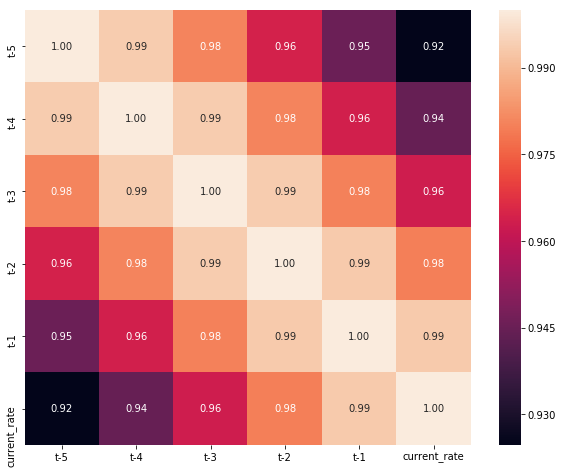

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), fmt='.2f', annot=True, ax=ax)

Text(0, 0.5, '% pa')

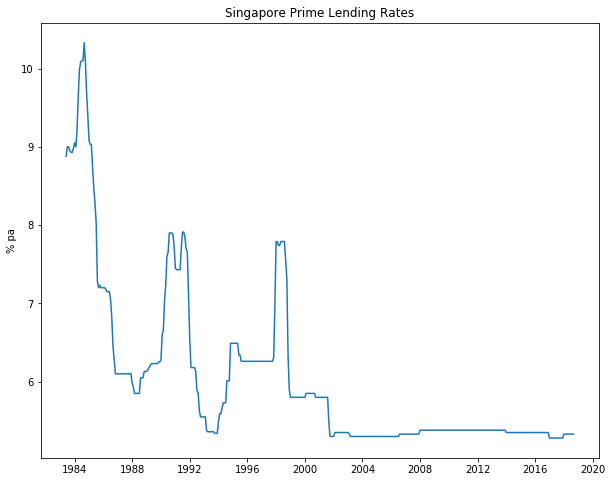

In [85]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['current_date'], df['current_rate'])
ax.set_title('Singapore Prime Lending Rates')
ax.set_ylabel('% pa')

## Feature reduction & scaling (not needed)

- Feature reduction is not needed because the number of features is small and we are trying to predict a trend from past values.

- Feature scaling is not needed because the columns are all historical interest rates (same ranges).

## Train model

Omit the current_date column when predicting the interest rates. 

- X should be the interest rate history columns
- y should be the current_rate column
- Hold out the 2018 interest rates as test data

In [86]:
features = (df.columns != 'current_date') & (df.columns != 'current_rate')
target = 'current_rate'
train_range = df['current_date'] < '2018-01-01'
test_range = df['current_date'] >= '2018-01-01'

X_train = df.loc[train_range, features]
y_train = df.loc[train_range, target]
X_test = df.loc[test_range, features]
y_test = df.loc[test_range, target]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(415, 5) (415,)
(9, 5) (9,)


In [87]:
estimator = SGDRegressor(random_state=42, tol=1e-3, max_iter=1000)

sample_sizes, train_scores, val_scores = learning_curve(estimator, X_train, y_train, cv=3, random_state=42)

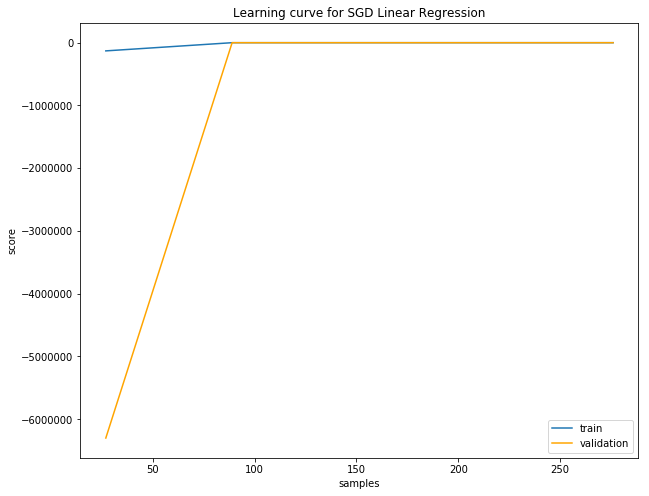

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(sample_sizes, train_scores.mean(axis=1), label='train')
ax.plot(sample_sizes, val_scores.mean(axis=1), color='orange', label='validation')
ax.set(xlabel='samples', ylabel='score', title='Learning curve for SGD Linear Regression')
ax.legend()

In [89]:
# Learning curve shows that we can use the entire training set without overfitting

model = SGDRegressor(random_state=42, tol=1e-3, max_iter=1000, verbose=True)
model.fit(X_train, y_train)

-- Epoch 1
Norm: 0.46, NNZs: 5, Bias: 0.066698, T: 415, Avg. loss: 0.983918
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.47, NNZs: 5, Bias: 0.067804, T: 830, Avg. loss: 0.039264
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.48, NNZs: 5, Bias: 0.072215, T: 1245, Avg. loss: 0.033612
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 5, Bias: 0.076256, T: 1660, Avg. loss: 0.030215
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.51, NNZs: 5, Bias: 0.079280, T: 2075, Avg. loss: 0.027664
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.53, NNZs: 5, Bias: 0.082914, T: 2490, Avg. loss: 0.024424
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.54, NNZs: 5, Bias: 0.083836, T: 2905, Avg. loss: 0.026230
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.55, NNZs: 5, Bias: 0.086204, T: 3320, Avg. loss: 0.024031
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.58, NNZs: 5, Bias: 0.090105, T: 3735, Avg. loss: 0.021149
Total training time: 0.00 sec

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=True, warm_start=False)

## Evaluation metrics

Use mean_squared_error, mean_absolute_error

In [90]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.00026892426979954726
0.010446209622847431


## Deployment and Prediction

* Save the model
* Load it from file
* Get predictions for the 2018 interest rates.
* Optional: Get predictions for the whole series and plot it.

In [91]:
# Inventory: model only
pickle.dump(model, open('interest_rates_model.pickle', 'wb'))

In [92]:
model1 = pickle.load(open('interest_rates_model.pickle', 'rb'))

In [93]:
y_pred = model1.predict(X_test)
print('Prediction:', y_pred)
print('Actual:', y_test.values)

Prediction: [5.28547153 5.31486206 5.3304929  5.3371771  5.3387139  5.33449139
 5.33449139 5.33449139 5.33449139]
Actual: [5.33 5.33 5.33 5.33 5.33 5.33 5.33 5.33 5.33]


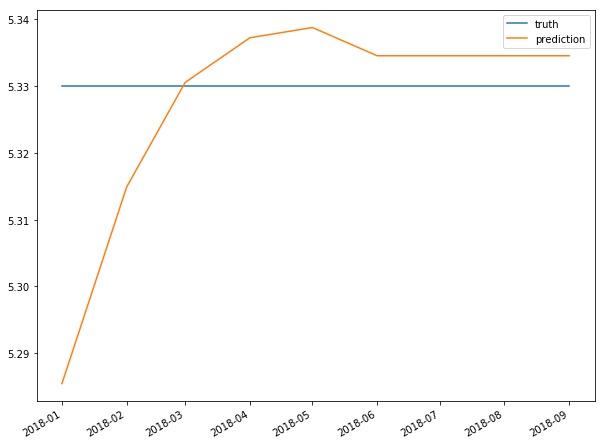

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))

pred_range = df['current_date'] >= '2018-01-01'
ax.plot(df.loc[pred_range, 'current_date'], y_test.values, label='truth')
ax.plot(df.loc[pred_range, 'current_date'], y_pred, label='prediction')

ax.legend()
fig.autofmt_xdate()

In [95]:
model1.coef_

array([-0.08445015,  0.03073588,  0.13368407,  0.31261685,  0.58781066])

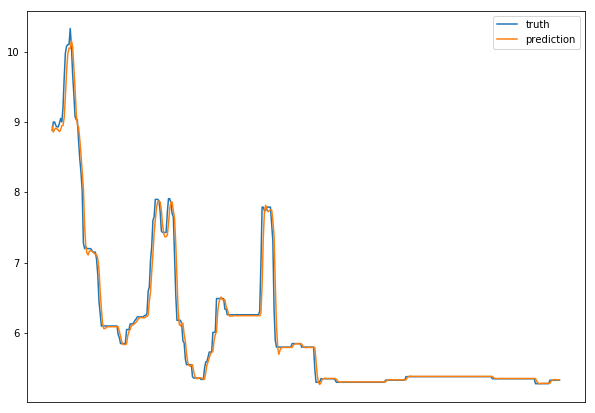

In [96]:
# show the whole series

X = df.loc[:, features]
y = df.loc[:, target]
y_pred = model1.predict(X)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['current_date'], y, label='truth')
ax.plot(df['current_date'], y_pred, label='prediction')

ax.set_xticks(ax.get_xticks()[::50])

ax.legend()
fig.autofmt_xdate()

## Appendix 1: Sequences to Windows

The data provided is already in 6-month window format. Here's how to convert a sequence into a windowed format in order to make this a supervised learning problem.

In [97]:
df_raw = pd.read_csv('./sg-interest-rates/prime_lending_rates_1983-2018.csv', index_col=0, parse_dates=True)

df_raw.head()

,Date,Prime_Lending_Rate_precent_pa
0,1983-01-01,9.53
1,1983-02-01,9.25
2,1983-03-01,9.10
3,1983-04-01,9.03
4,1983-05-01,9.03


In [98]:
# Try to shift up
df_raw.shift(-1).head()

,Date,Prime_Lending_Rate_precent_pa
0,1983-02-01,9.25
1,1983-03-01,9.10
2,1983-04-01,9.03
3,1983-05-01,9.03
4,1983-06-01,8.88


In [99]:
# Try to shift up more
df_raw.shift(-2).head()

,Date,Prime_Lending_Rate_precent_pa
0,1983-03-01,9.10
1,1983-04-01,9.03
2,1983-05-01,9.03
3,1983-06-01,8.88
4,1983-07-01,9.00


In [102]:
p = 6

series = [df_raw['Prime_Lending_Rate_precent_pa'].shift(-i) for i in range(p)]

# let's make nicer column names
columns = [f't+{i}' for i in range(p)]

df_windowed = pd.concat(series, axis=1)
df_windowed.columns = columns
df_windowed

,t+0,t+1,t+2,t+3,t+4,t+5
0,9.53,9.25,9.10,9.03,9.03,8.88
1,9.25,9.10,9.03,9.03,8.88,9.00
2,9.10,9.03,9.03,8.88,9.00,9.00
3,9.03,9.03,8.88,9.00,9.00,8.95
4,9.03,8.88,9.00,9.00,8.95,8.93
5,8.88,9.00,9.00,8.95,8.93,8.93
6,9.00,9.00,8.95,8.93,8.93,8.98
7,9.00,8.95,8.93,8.93,8.98,9.05
8,8.95,8.93,8.93,8.98,9.05,9.00
9,8.93,8.93,8.98,9.05,9.00,9.20


In [103]:
# We can drop the NaNs (values in the future)

df_windowed.dropna(inplace=True)
df_windowed

,t+0,t+1,t+2,t+3,t+4,t+5
0,9.53,9.25,9.10,9.03,9.03,8.88
1,9.25,9.10,9.03,9.03,8.88,9.00
2,9.10,9.03,9.03,8.88,9.00,9.00
3,9.03,9.03,8.88,9.00,9.00,8.95
4,9.03,8.88,9.00,9.00,8.95,8.93
5,8.88,9.00,9.00,8.95,8.93,8.93
6,9.00,9.00,8.95,8.93,8.93,8.98
7,9.00,8.95,8.93,8.93,8.98,9.05
8,8.95,8.93,8.93,8.98,9.05,9.00
9,8.93,8.93,8.98,9.05,9.00,9.20


In [104]:
# now we can save it to a csv for future use
df_windowed.to_csv('df_windowed.csv', index=False)

## Appendix 2: Autocorrelation plots

Autocorrelation plots are a way to visualise how far back a current value is correlated to values in the past.

This can be used to determine the limits of the window size.

In [106]:
# must use original (non-windowed series for autocorrelation plot)
df_raw['Prime_Lending_Rate_precent_pa'].head()

0    9.53
1    9.25
2    9.10
3    9.03
4    9.03
Name: Prime_Lending_Rate_precent_pa, dtype: float64

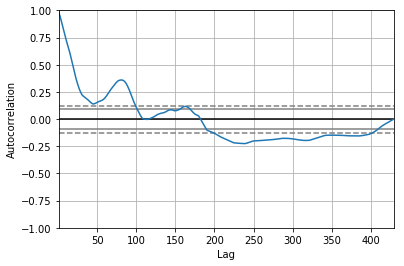

In [105]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_raw['Prime_Lending_Rate_precent_pa'])

https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#autocorrelation-plot

The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

If time series is random, such autocorrelations should be near zero for any and all time-lag separations. 

![random](https://www.itl.nist.gov/div898/handbook/eda/section3/gif/autocop1.gif)

If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

You can also observe seasonal or cyclical dependencies in these plots:
![seasonal](https://pandas.pydata.org/pandas-docs/stable/_images/autocorrelation_plot.png)